In [8]:
!pip install BeautifulSoup4

In [9]:
import os
import json
import time
import random
import zipfile
import requests
import pandas as pd
import csv
import re
from bs4 import BeautifulSoup

# Class Explanation: `NewsScraper`

## Overview
The `NewsScraper` class is designed for scraping news articles from three different Urdu news websites: Geo, Jang, and Express. The class has methods that cater to each site's unique structure and requirements. Below, we will go through the class and its methods, detailing what each function does, the input it takes, and the output it returns.

## Class Definition

```python
class NewsScraper:
    def __init__(self, id_=0):
        self.id = id_
```


## Method 1: `get_express_articles`

### Description
Scrapes news articles from the Express website across categories like saqafat (entertainment), business, sports, science-technology, and world. The method navigates through multiple pages for each category to gather a more extensive dataset.

### Input
- **`max_pages`**: The number of pages to scrape for each category (default is 7).

### Process
- Iterates over each category and page.
- Requests each category page and finds article cards within `<ul class='tedit-shortnews listing-page'>`.
- Extracts the article's headline, link, and content by navigating through `<div class='horiz-news3-caption'>` and `<span class='story-text'>`.

### Output
- **Returns**: A tuple of:
  - A Pandas DataFrame containing columns: `id`, `title`, and `link`).
  - A dictionary `express_contents` where the key is the article ID and the value is the article content.

### Data Structure
- Article cards are identified by `<li>` tags.
- Content is structured within `<span class='story-text'>` and `<p>` tags.



# Web Scrapping
- Geo, Express, Samaa, Jang News

EXPRESS NEWS

In [10]:
class Express_Scraper:
    def __init__(self,id_=0):
        self.id = id_

    def get_express_articles(self, max_pages=15):
        express_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://www.express.pk'
        categories = ['saqafat', 'business', 'sports', 'science', 'world']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(1, max_pages + 1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/{category}/archives?page={page}"
                response = requests.get(url)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.find('ul', class_='tedit-shortnews listing-page').find_all('li')  # Adjust class as per actual site structure
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('div',class_='horiz-news3-caption')

                        # Article Title
                        headline = div.find('a').get_text(strip=True).replace('\xa0', ' ')

                        # Article link
                        link = div.find('a')['href']

                        # Requesting the content from each article's link
                        article_response = requests.get(link)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")


                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('span',class_='story-text').find_all('p')

                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                        )

                        # Storing data
                        express_df['id'].append(self.id)
                        express_df['title'].append(headline)
                        express_df['link'].append(link)
                        express_df['gold_label'].append(category.replace('saqafat','entertainment').replace('science','science-technology'))
                        express_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
            print('')

        return pd.DataFrame(express_df)


GEO NEWS

In [11]:

class Geo_Scraper:
    def __init__(self,id_=0):
        self.id = id_

    def get_geo_articles(self, max_articles_per_category=60):
        geo_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        categories = {
            "sports": "https://urdu.geo.tv/category/sports",
            "science": "https://urdu.geo.tv/category/science-technology",
            "business": "https://urdu.geo.tv/category/business",
            "world": "https://urdu.geo.tv/category/world",
            "entertainment": "https://urdu.geo.tv/category/entertainment"
        }
        for category, url in categories.items():
            article_count = 0
            print(f"Scraping articles for category '{category}'...")
            response = requests.get(url)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, "html.parser")
            articles = soup.find_all("li", class_="border-box")
            if not articles:
                print(f"No articles found in category '{category}'")
                continue
            for article in articles:
                title_tag = article.find("a", class_="open-section")
                title = title_tag.get("title", "Title not found")
                link = title_tag["href"]
                if link.endswith('-'):
                    article_id = link.split('-')[-1] 
                    if len(article_id) <= 3:
                        next_two_digits = article_id[2:]  
                        link = link + next_two_digits
                    else:
                        link = link + article_id[:2]  
                article_response = requests.get(link)
                article_response.raise_for_status()
                article_soup = BeautifulSoup(article_response.text, "html.parser")
                content_div = article_soup.find("div", class_="content-area")
                paragraphs = content_div.find_all("p") if content_div else []
                content = " ".join(p.get_text(strip=True) for p in paragraphs)
                geo_df["id"].append(self.id)
                geo_df["title"].append(title)
                geo_df["link"].append(link)
                geo_df["content"].append(content)
                geo_df["gold_label"].append(category)
                self.id += 1
                article_count += 1
                print(f"\t--> Scraped article {article_count} in category '{category}'.")
                if article_count >= max_articles_per_category:
                    break
            print(f"Completed scraping {article_count} articles from category '{category}'.")
        df = pd.DataFrame(geo_df)
        return df
    
    def save_to_csv(self, df, filename="geo_articles.csv"):
        with open(filename, mode="w", newline="", encoding="utf-8") as file:
            writer = csv.writer(file, quotechar='"', quoting=csv.QUOTE_ALL)
            writer.writerow(["ID", "Title", "Link", "Content", "Gold Label"])
            for _, row in df.iterrows():
                writer.writerow([row["id"], row["title"], row["link"], row["content"], row["gold_label"]])
        print(f"Articles saved to {filename}")


SAMAA TV

In [12]:

class Samaa_Scraper:
    def __init__(self):
        self.base_url = "https://urdu.samaa.tv" 
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'
        }
        self.articles = []

    def fetch_category_articles(self, category_url, category_name):
        """
        Fetches up to 80 articles from a category page with pagination.
        """
        page = 1
        while len([a for a in self.articles if a['gold_label'] == category_name]) < 200:
            url = f"{category_url}?page={page}"
            print(f"Fetching page: {url}")
            response = requests.get(url, headers=self.headers)  
            print("response: ", response)
            if response.status_code == 403:
                print(f"Access forbidden (403) for {url}. Check headers or other access restrictions.")
                break
            elif response.status_code != 200:
                print(f"Error fetching page {page} of {category_name}. Status code: {response.status_code}")
                break
            soup = BeautifulSoup(response.text, 'html.parser')
            articles_in_category = []
            for article in soup.select('article.story-article'):
                title = article.h3.a.text.strip()
                link = article.h3.a['href']
                if not link.startswith("http"):
                    link = self.base_url + link
                full_content = self.fetch_article_content(link)
                articles_in_category.append({
                    'id': len(self.articles) + len(articles_in_category),
                    'title': title,
                    'link': link,
                    'content': full_content,
                    'gold_label': category_name
                })
                if len(articles_in_category) + len([a for a in self.articles if a['gold_label'] == category_name]) >= 200:
                    break
            if not articles_in_category:
                break  
            self.articles.extend(articles_in_category)
            page += 1

    def fetch_article_content(self, url):
        """
        Fetches the full content of an article from its URL.
        """
        response = requests.get(url, headers=self.headers) 
        article_soup = BeautifulSoup(response.text, 'html.parser')
        content_div = article_soup.find('div', class_='article-content')
        if content_div:
            paragraphs = content_div.find_all('p')
            full_content = ' '.join(paragraph.text.strip() for paragraph in paragraphs)
            return full_content
        else:
            print(f"Warning: No content found for URL {url}")
            return ""

    def scrape(self, categories):
        """
        Main scraping function to fetch articles from multiple categories.
        """
        for category_name, category_url in categories.items():
            print(f"Scraping category: {category_name}")
            self.fetch_category_articles(category_url, category_name)
            print(f"Found {len([a for a in self.articles if a['gold_label'] == category_name])} articles in {category_name}.")

    def save_to_csv(self, filename="articles.csv"):
        """
        Saves the scraped articles to a CSV file with quotes around text fields.
        """
        with open(filename, mode="w", newline="", encoding="utf-8") as file:
            writer = csv.writer(file, quoting=csv.QUOTE_ALL) 
            writer.writerow(["id", "title", "link", "content", "gold_label"])
            for article in self.articles:
                writer.writerow([article['id'], article['title'], article['link'], article['content'],  article['gold_label']])
        print(f"Articles saved to {filename}")


JUNG NEWS

In [ ]:

# list of categories
cats = ["World News", "Sports News", "Science & Technology News", "Business News", "Entertainment News"]
class Jang_Scraper:
    def __init__(self, id_=0):
        self.id = id_

    def get_category_links(self, base_url):
        response = requests.get(base_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        footer_links = {}
        footer_section = soup.find('section', class_='footer')

        if footer_section:
            footer_content = footer_section.find('div', class_='footer_content')
            if footer_content:
                first_row = footer_content.find('div', class_='first_footer')
                if first_row:
                    col = first_row.find('div', class_='col-lg-3 col-md-3 col-sm-6 col-xs-6 h_footer')
                    if col:
                        footer_list = col.find('ul', class_='footer-list')
                        if footer_list:
                            footer_quick1 = footer_list.find('div', class_='footer-quick1')

                            if footer_quick1:
                                for li in footer_quick1.find_all('li'):
                                    a_tag = li.find('a')
                                    if a_tag and 'href' in a_tag.attrs:
                                        category_url = a_tag['href']
                                        category_title = a_tag.get_text(strip=True)

                                        # check if the category title is in the `cats` list
                                        if category_title in cats:
                                            # extract the last part of the URL to use as the category label
                                            label = re.search(r'/([^/]+)$', category_url).group(1)
                                            footer_links[category_url] = label

        return footer_links

    def get_articles_from_category(self, category_url, label, max_pages=1):
        articles_data = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": []
        }

        for page in range(1, max_pages + 1):
            page_url = f"{category_url}?page={page}" if page > 1 else category_url
            response = requests.get(page_url)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, 'html.parser')

            try:
                latest_page = soup.find('section', class_='latest_page')
                if latest_page:
                    latest_page_list = soup.find('section', class_='latest_page_list')
                    if latest_page_list:
                        container = latest_page_list.find('div', class_='container')
                        if container:
                            latest_page_right = container.find('div', class_='latest_page_right')
                            if latest_page_right:
                                scroll_pagination = latest_page_right.find('ul', class_='scrollPaginationNew__')
                                if scroll_pagination:
                                    for li in scroll_pagination.find_all('li'):
                                        main_heading = li.find('div', class_='main-heading')
                                        if main_heading:
                                            a_tag = main_heading.find('a')
                                            if a_tag and 'href' in a_tag.attrs:
                                                article_url = a_tag['href']
                                                full_url = f"{article_url}"
                                                article_response = requests.get(full_url)
                                                article_response.raise_for_status()
                                                content_soup = BeautifulSoup(article_response.text, "html.parser")

                                                # get article title
                                                title_div = content_soup.find('section', class_='detail-page')
                                                if title_div:
                                                    container = title_div.find('div', class_='container')
                                                    if container:
                                                        detail_right = container.find('div', class_='detail-right')
                                                        if detail_right:
                                                            detail_right_top = detail_right.find('div', class_='detail-right-top')
                                                            if detail_right_top:
                                                                title_tag = detail_right_top.find('h1')
                                                                if title_tag:
                                                                    title = title_tag.get_text(strip=True)
                                                                else:
                                                                    title = "No title found"
                                                            
                                                            # get article content
                                                            detail_content = detail_right.find('div', class_='detail-content')
                                                            if detail_content:
                                                                description_area = detail_content.find('div', class_='description-area')
                                                                if description_area:
                                                                    detail_view_content = description_area.find('div', class_='detail_view_content')
                                                                    if detail_view_content:
                                                                        paragraphs = detail_view_content.find_all('p')
                                                                        article_content = " ".join([para.get_text(strip=True) for para in paragraphs])
                                                                    else:
                                                                        article_content = "No content found"
                                                            else:
                                                                article_content = "No content found"
                                                            
                                                            # Add data to articles_data
                                                            articles_data["id"].append(self.id)
                                                            articles_data["title"].append(title)
                                                            articles_data["link"].append(full_url)
                                                            articles_data["content"].append(article_content)
                                                            articles_data["gold_label"].append(label)

                                                            # print statement after each article is added
                                                            print(f"Added article: {title}")

                                                            self.id += 1

            except AttributeError as e:
                pass

        return articles_data

    def get_all_articles(self, base_url, max_pages=1):
        category_links = self.get_category_links(base_url)

        all_articles = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": []
        }

        for category_url, label in category_links.items():
            category_data = self.get_articles_from_category(category_url, label, max_pages)
            for key in all_articles:
                all_articles[key].extend(category_data[key])

        return pd.DataFrame(all_articles)

- Data stored in files.


In [ ]:
# Express News
express_scraper = Express_Scraper()
express_df = express_scraper.get_express_articles()
express_df['gold_label'] = express_df['gold_label'].replace('saqafat', 'entertainment')
express_df.to_csv("express_articles.csv", index=False)

In [ ]:
# Geo News
geo_scraper = Geo_Scraper()
df = geo_scraper.get_geo_articles(max_articles_per_category=60)
geo_scraper.save_to_csv(df, filename="geo_articles.csv")

In [ ]:
# Sammaa News
categories = {
    "business": "https://urdu.samaa.tv/money",
    "science": "https://urdu.samaa.tv/tech",
    "world": "https://urdu.samaa.tv/global",
    "sports": "https://urdu.samaa.tv/sports",
    "entertainment": "https://urdu.samaa.tv/lifestyle",
}
scraper = Samaa_Scraper()
scraper.scrape(categories)
scraper.save_to_csv("samaa_articles.csv")

In [ ]:
# Jang News
scraper = Jang_Scraper()
base_url = "https://jang.com.pk/"
articles_df = scraper.get_all_articles(base_url, max_pages=1)
articles_df.to_csv("jang_articles.csv", index=False)

# Output
- Save a combined csv of all 4 sites.

In [16]:
import glob
import pandas as pd

all_files = glob.glob("*.csv")
column_names = ["id", "title", "link", "content", "gold_label"]
combined_df = pd.concat(
    (pd.read_csv(f, names=column_names, header=0) for f in all_files), ignore_index=True
)
combined_df = combined_df.drop_duplicates(subset=["title", "link", "content"])
combined_df["gold_label"] = combined_df["gold_label"].replace({
    "health-science": "science-technology",
    "business": "business",
    "entertainment": "entertainment",
    "world": "international",
    "science": "science-technology"
})
combined_df["id"] = range(len(combined_df))
combined_df.to_csv("combined_articles.csv", index=False)


# Processing & Cleaning
- Data cleaned for model training.

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Salaar
[nltk_data]     Masood\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package punkt to C:\Users\Salaar
[nltk_data]     Masood\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Salaar Masood\AppData\Local\Temp\ipykernel_19608\1580265239.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='gold_label', palette='Set2')


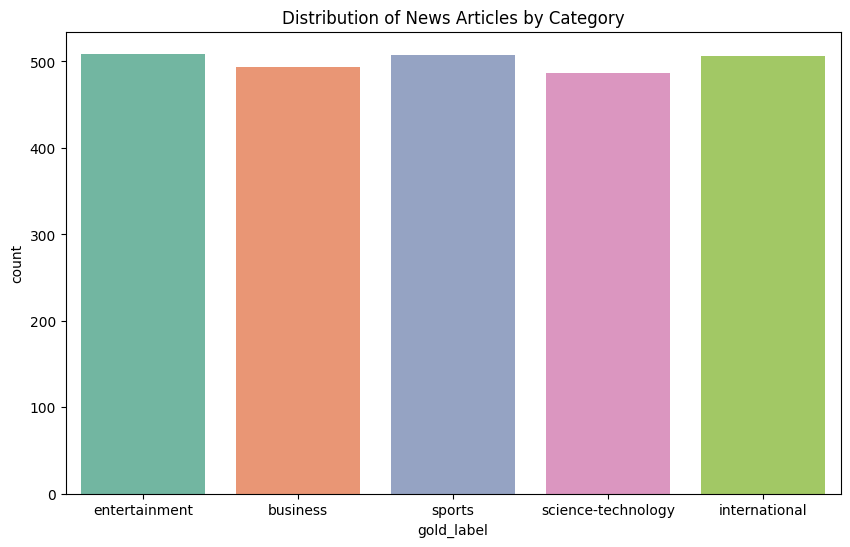

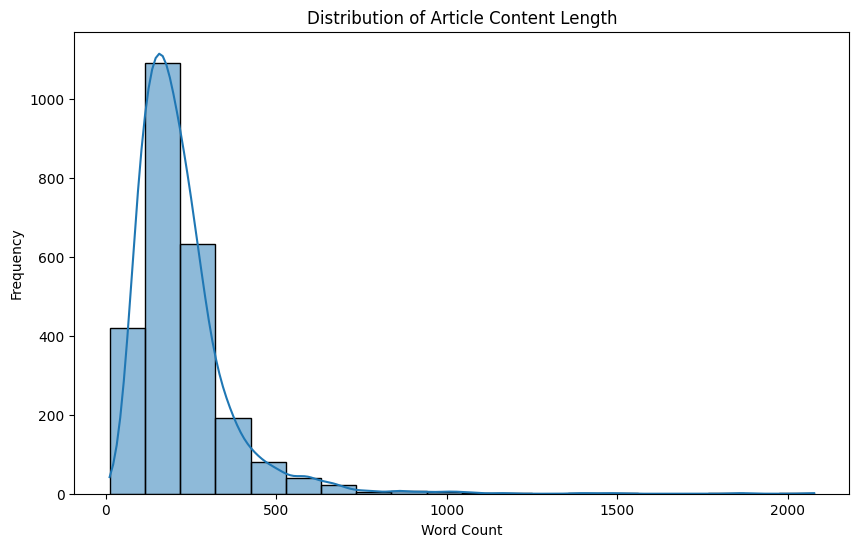

Data cleaning and EDA completed


In [ ]:
import nltk
nltk.download('punkt')
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import re
import seaborn as sns

# Load the dataset
df = pd.read_csv("combined_articlesv2.csv")

df["gold_label"] = df["gold_label"].replace({
    "Entertainment": "entertainment",
    "Business": "business",
    "Sports": "sports",
    "International": "international",
    "Science & Technology": "science-technology"
})

# drop rows with missing content
df = df.dropna(subset=['content'])

from urduhack.normalization import normalize

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\b[a-zA-Z]+\b', '', text)  # remove English words
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    # remove non-Urdu characters
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    # remove diacritics
    text = re.sub(r'[ًٌٍَُِّْ]', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    text = normalize(text)
    return text

df['title'] = df['title'].apply(preprocess_text)
df['content'] = df['content'].apply(preprocess_text)

df = df[df['content'].str.strip() != '']
df = df.drop_duplicates(subset=['title', 'content'])
df['id'] = range(len(df))
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='gold_label', palette='Set2')
plt.title("Distribution of News Articles by Category")
plt.show()
df['content_length'] = df['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['content_length'], bins=20, kde=True)
plt.title("Distribution of Article Content Length")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()
df.to_csv("cleaned_articles_with_numbers_v2.csv", index=False)
print("Data cleaning and EDA completed")
